In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from google.colab import files

In [2]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 98% 602M/612M [00:07<00:00, 85.2MB/s]
100% 612M/612M [00:07<00:00, 89.1MB/s]


In [3]:
!unzip -qq gtsrb-german-traffic-sign.zip

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
dataset_root = "/content"
r_size = (32,32)

In [6]:
def resize_image(image, size=(32,32)):
    return cv2.resize(image, size)

In [7]:
def normalize_image(image):
    return image / 255.0

In [8]:
def one_hot_encode(labels):
    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    encoder.fit(labels)
    return encoder.transform(labels)

In [9]:
def load_data(folder):
    images = []
    labels = []

    train_df = pd.read_csv(os.path.join(dataset_root, folder))

    for index, row in train_df.iterrows():
        image_file = row['Path']
        image_path = os.path.join(dataset_root, image_file)

        image = cv2.imread(image_path)
        image = resize_image(image)
        image = normalize_image(image)

        images.append(image)
        labels.append(row['ClassId'])

    images = np.array(images)
    labels = np.array(labels)

    labels = one_hot_encode(labels)

    return images, labels

In [10]:
images, labels = load_data("Train.csv")

print(images.shape)
print(labels.shape)

(39209, 32, 32, 3)
(39209, 43)


In [11]:
test_images, test_labels = load_data('Test.csv')

print(test_images.shape)
print(test_labels.shape)

(12630, 32, 32, 3)
(12630, 43)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, random_state = 42)



X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(test_images, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 43)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = x.reshape(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0

        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')

        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')


        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [38]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

Epoch 1/50, Loss: 1.2371, Validation Accuracy: 0.8249
[EarlyStopping] (Update) Best Score: 0.82492
Epoch 2/50, Loss: 0.2812, Validation Accuracy: 0.9485
[EarlyStopping] (Update) Best Score: 0.94848
Epoch 3/50, Loss: 0.1472, Validation Accuracy: 0.9700
[EarlyStopping] (Update) Best Score: 0.97003
Epoch 4/50, Loss: 0.1060, Validation Accuracy: 0.9843
[EarlyStopping] (Update) Best Score: 0.98432
Epoch 5/50, Loss: 0.0816, Validation Accuracy: 0.9843
[EarlyStopping] (Patience) 1/3, Best: 0.98432, Current: 0.98432, Delta: 0.00000
Epoch 6/50, Loss: 0.0666, Validation Accuracy: 0.9893
[EarlyStopping] (Update) Best Score: 0.98929
Epoch 7/50, Loss: 0.0557, Validation Accuracy: 0.9899
[EarlyStopping] (Patience) 1/3, Best: 0.98929, Current: 0.98993, Delta: 0.00064
Epoch 8/50, Loss: 0.0502, Validation Accuracy: 0.9874
[EarlyStopping] (Patience) 2/3, Best: 0.98929, Current: 0.98738, Delta: 0.00191
Epoch 9/50, Loss: 0.0486, Validation Accuracy: 0.9936
[EarlyStopping] (Update) Best Score: 0.99362
Epoc

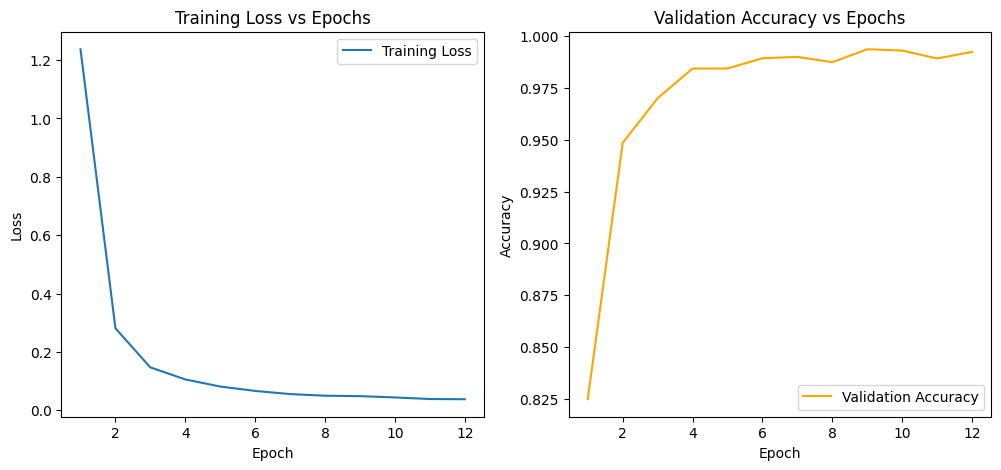

In [57]:
model = CNN().to(device)

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 얼리 스톰 추가
early_stopping = EarlyStopping(patience=3, delta=0.001, mode='max', verbose=True)

num_epochs = 50
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # EarlyStopping 호출
    early_stopping(val_accuracy)

    if early_stopping.early_stop:
        print("Early stopping")
        break

print(f"Validation Accuracy: {correct / total}")

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()

plt.show()


In [58]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0,3,1,2)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

print(f"Test Accuracy: {correct / total}")

Test Accuracy: 0.9505146476642914
